<a href="https://colab.research.google.com/github/Rodrigo2S/Atividade_Visualizacao_de_dados/blob/main/Atividade_Visualiza%C3%A7%C3%A3o_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import auth
import missingno as msno
from sklearn.covariance import EllipticEnvelope
import seaborn as sns
import matplotlib.pyplot as plt
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
PROJECT_ID = 'ds-project-353020'

In [3]:
QUERY = f'''WITH usuarios AS (
                SELECT
                    id as user_id,
                    operating_system,
                    salary,
                    credit_score,
                    date_birth,
                    DATE_DIFF(DATE(DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY)), DATE(date_birth), YEAR) as age
                FROM
                `ds-project-353020.app_data.users_profile`
), eventos AS (
                SELECT
                    user_id,
                    SUM(CASE WHEN event_name = 'app.home_view' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_home_view_last_7_days,
                    SUM(CASE WHEN event_name = 'app.home_view' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_home_view_last_15_days,
                    SUM(CASE WHEN event_name = 'app.search' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_searches_last_7_days,
                    SUM(CASE WHEN event_name = 'app.search' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_searches_last_15_days,
                    SUM(CASE WHEN event_name = 'app.search' AND section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_restaurant_searches_last_7_days,
                    SUM(CASE WHEN event_name = 'app.search' AND section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_restaurant_searches_last_15_days,
                    SUM(CASE WHEN event_name = 'app.search' AND section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_supermarket_searches_last_7_days,
                    SUM(CASE WHEN event_name = 'app.search' AND section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) AS qtd_supermarket_searches_last_15_days,
                    SUM(CASE WHEN event_name = 'app.added_to_cart' AND section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) AS sum_total_value_restaurant_add_cart_last_7_days,   
                    SUM(CASE WHEN event_name = 'app.added_to_cart' AND section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) AS sum_total_value_restaurant_add_cart_last_15_days,
                    SUM(CASE WHEN event_name = 'app.added_to_cart' AND section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) AS sum_total_value_supermarket_add_cart_last_7_days,   
                    SUM(CASE WHEN event_name = 'app.added_to_cart' AND section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) AS sum_total_value_supermarket_add_cart_last_15_days    
                FROM
                `ds-project-353020.app_data.events`
                WHERE DATE(date) <= DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) -- selecionando apenas eventos anteriores a data de corte, 7 dia antes da ultima data disponivel na base de dados
                GROUP BY user_id
), pedidos_anteriores AS (
                        SELECT 
                            user_id,
                            SUM(total_value) as sum_total_value_orders,
                            AVG(total_value) as avg_total_value_orders,
                            SUM(CASE WHEN section = 'restaurant' THEN total_value END ) AS sum_total_value_restaurant_orders,
                            SUM(CASE WHEN section = 'supermarket' THEN total_value END ) AS sum_total_value_supermarket_orders,  
                            AVG(CASE WHEN section = 'restaurant' THEN total_value END ) AS avg_total_value_restaurant_orders,
                            AVG(CASE WHEN section = 'supermarket' THEN total_value END ) AS avg_total_value_supermarket_orders,  
                            SUM(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_orders_last_7_days,
                            SUM(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_orders_last_15_days,
                            AVG(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as avg_total_value_orders_last_7_days,
                            AVG(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as avg_total_value_orders_last_15_days,
                            SUM(CASE WHEN section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_restaurant_orders_last_7_days,
                            SUM(CASE WHEN section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_restaurant_orders_last_15_days,
                            SUM(CASE WHEN section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_supermarket_orders_last_7_days,
                            SUM(CASE WHEN section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN total_value ELSE 0 END) as sum_total_value_supermarket_orders_last_15_days,
                            COUNT(*) as qtd_orders,
                            SUM(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_orders_last_7_days,
                            SUM(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_orders_last_15_days,
                            SUM(CASE WHEN section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_restaurant_orders_last_7_days,
                            SUM(CASE WHEN section = 'restaurant' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_restaurant_orders_last_15_days,
                            SUM(CASE WHEN section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -14 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_supermarket_orders_last_7_days,
                            SUM(CASE WHEN section = 'supermarket' AND DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -22 DAY) AND DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) THEN 1 ELSE 0 END) as qtd_supermarket_orders_last_15_days,
                            SUM(CASE WHEN payment_method = 'credit_card' THEN 1 ELSE 0 END) / COALESCE(COUNT(*), 1) AS taxa_credit_card_payments
                        FROM
                            `ds-project-353020.app_data.orders`
                        WHERE DATE(date) <= DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) -- selecionando apenas pedidos anteriores a data de corte, 7 dia antes da ultima data disponivel na base de dados
                        GROUP BY user_id

), target AS (
            SELECT 
                user_id,
                MAX(CASE WHEN DATE(date) BETWEEN DATE_ADD(DATE "2021-05-31", INTERVAL -7 DAY) AND DATE('2021-05-31') THEN 1 ELSE 0 END) AS target
            FROM
            `ds-project-353020.app_data.orders`
            GROUP BY user_id
)
SELECT 
    usuarios.user_id,
    usuarios.operating_system,
    usuarios.salary,
    usuarios.credit_score,
    usuarios.age,
    eventos.qtd_home_view_last_7_days,
    eventos.qtd_home_view_last_15_days,
    eventos.qtd_searches_last_7_days,
    eventos.qtd_searches_last_15_days,
    eventos.qtd_restaurant_searches_last_7_days,
    eventos.qtd_restaurant_searches_last_15_days,
    eventos.qtd_supermarket_searches_last_7_days,
    eventos.qtd_supermarket_searches_last_15_days,
    eventos.sum_total_value_restaurant_add_cart_last_7_days,   
    eventos.sum_total_value_restaurant_add_cart_last_15_days,
    eventos.sum_total_value_supermarket_add_cart_last_7_days,   
    eventos.sum_total_value_supermarket_add_cart_last_15_days,    
    pedidos_anteriores.sum_total_value_orders,
    pedidos_anteriores.avg_total_value_orders,
    pedidos_anteriores.sum_total_value_restaurant_orders,
    pedidos_anteriores.sum_total_value_supermarket_orders,  
    pedidos_anteriores.avg_total_value_restaurant_orders,
    pedidos_anteriores.avg_total_value_supermarket_orders,  
    pedidos_anteriores.sum_total_value_orders_last_7_days,
    pedidos_anteriores.sum_total_value_orders_last_15_days,
    pedidos_anteriores.avg_total_value_orders_last_7_days,
    pedidos_anteriores.avg_total_value_orders_last_15_days,
    pedidos_anteriores.sum_total_value_restaurant_orders_last_7_days,
    pedidos_anteriores.sum_total_value_restaurant_orders_last_15_days,
    pedidos_anteriores.sum_total_value_supermarket_orders_last_7_days,
    pedidos_anteriores.sum_total_value_supermarket_orders_last_15_days,
    pedidos_anteriores.qtd_orders_last_7_days,
    pedidos_anteriores.qtd_orders_last_15_days,
    pedidos_anteriores.qtd_restaurant_orders_last_7_days,
    pedidos_anteriores.qtd_restaurant_orders_last_15_days,
    pedidos_anteriores.qtd_supermarket_orders_last_7_days,
    pedidos_anteriores.qtd_supermarket_orders_last_15_days,
    pedidos_anteriores.taxa_credit_card_payments,
    target.target
FROM 
usuarios
LEFT JOIN
eventos
ON usuarios.user_id = eventos.user_id
LEFT JOIN
pedidos_anteriores
ON usuarios.user_id = pedidos_anteriores.user_id
LEFT JOIN 
target
ON usuarios.user_id = target.user_id 
'''

In [4]:
df = pd.io.gbq.read_gbq(QUERY, project_id=PROJECT_ID)

In [5]:
pd.options.display.max_columns = None
df.head()

,user_id,operating_system,salary,credit_score,age,qtd_home_view_last_7_days,qtd_home_view_last_15_days,qtd_searches_last_7_days,qtd_searches_last_15_days,qtd_restaurant_searches_last_7_days,qtd_restaurant_searches_last_15_days,qtd_supermarket_searches_last_7_days,qtd_supermarket_searches_last_15_days,sum_total_value_restaurant_add_cart_last_7_days,sum_total_value_restaurant_add_cart_last_15_days,sum_total_value_supermarket_add_cart_last_7_days,sum_total_value_supermarket_add_cart_last_15_days,sum_total_value_orders,avg_total_value_orders,sum_total_value_restaurant_orders,sum_total_value_supermarket_orders,avg_total_value_restaurant_orders,avg_total_value_supermarket_orders,sum_total_value_orders_last_7_days,sum_total_value_orders_last_15_days,avg_total_value_orders_last_7_days,avg_total_value_orders_last_15_days,sum_total_value_restaurant_orders_last_7_days,sum_total_value_restaurant_orders_last_15_days,sum_total_value_supermarket_orders_last_7_days,sum_total_value_supermarket_orders_last_15_days,qtd_orders_last_7_days,qtd_orders_last_15_days,qtd_restaurant_orders_last_7_days,qtd_restaurant_orders_last_15_days,qtd_supermarket_orders_last_7_days,qtd_supermarket_orders_last_15_days,taxa_credit_card_payments,target
0,8792,android,4682.76,781,47,4.0,12.0,8.0,15.0,2.0,3.0,1.0,4.0,84.01,366.20,11.00,208.17,2893.98,55.653462,533.99,284.00,16.181515,56.800000,1067.01,1971.89,20.519423,37.920962,84.01,366.20,11.00,208.17,15.0,38.0,10.0,26.0,2.0,4.0,0.769231,1.0
1,15536,ios,2675.78,551,47,5.0,12.0,23.0,45.0,7.0,18.0,9.0,15.0,212.00,406.34,901.00,969.58,1363.54,29.011489,504.90,750.64,22.950000,35.744762,752.96,1014.13,16.020426,21.577234,182.32,341.68,570.64,639.22,13.0,27.0,8.0,15.0,5.0,11.0,0.851064,1.0
2,16944,ios,3278.60,814,47,6.0,14.0,19.0,45.0,7.0,16.0,8.0,22.0,619.99,880.73,1530.01,1742.91,2754.75,45.159836,946.98,1799.77,31.566000,64.277500,1759.35,2192.71,28.841803,35.946066,505.18,733.32,1248.17,1451.39,17.0,39.0,8.0,19.0,8.0,17.0,0.786885,1.0
3,19636,ios,5209.68,606,47,0.0,0.0,12.0,16.0,10.0,14.0,0.0,0.0,986.00,2134.63,0.00,28.00,3008.99,158.367895,2980.99,28.00,165.610556,28.000000,986.00,2162.63,51.894737,113.822632,986.00,2134.63,0.00,28.00,9.0,16.0,9.0,15.0,0.0,1.0,0.736842,1.0
4,19294,ios,126.51,642,47,7.0,16.0,10.0,17.0,5.0,10.0,3.0,3.0,558.99,889.67,1240.00,2335.11,4149.73,125.749394,1130.17,3019.56,45.206800,377.445000,1798.99,2700.58,54.514848,81.835758,558.99,844.58,1240.00,1856.00,13.0,22.0,10.0,18.0,3.0,4.0,0.818182,1.0


In [6]:
df.shape

(20000, 39)

**temos 20 mil linhas e 39 colunas**

## Verificando se a quantidade de linhas confere com a quantidade de usuários distintos

In [7]:
df.user_id.nunique()

20000

In [8]:
df.shape[0] == df.user_id.nunique()

True

### Verificando o tipo de cada uma das colunas

In [9]:
df.dtypes

user_id                                                int64
operating_system                                      object
salary                                               float64
credit_score                                           int64
age                                                    int64
qtd_home_view_last_7_days                            float64
qtd_home_view_last_15_days                           float64
qtd_searches_last_7_days                             float64
qtd_searches_last_15_days                            float64
qtd_restaurant_searches_last_7_days                  float64
qtd_restaurant_searches_last_15_days                 float64
qtd_supermarket_searches_last_7_days                 float64
qtd_supermarket_searches_last_15_days                float64
sum_total_value_restaurant_add_cart_last_7_days      float64
sum_total_value_restaurant_add_cart_last_15_days     float64
sum_total_value_supermarket_add_cart_last_7_days     float64
sum_total_value_supermar

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 39 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   user_id                                            20000 non-null  int64  
 1   operating_system                                   20000 non-null  object 
 2   salary                                             20000 non-null  float64
 3   credit_score                                       20000 non-null  int64  
 4   age                                                20000 non-null  int64  
 5   qtd_home_view_last_7_days                          19668 non-null  float64
 6   qtd_home_view_last_15_days                         19668 non-null  float64
 7   qtd_searches_last_7_days                           19668 non-null  float64
 8   qtd_searches_last_15_days                          19668 non-null  float64
 9   qtd_re

#### Não Achei necessário ajustar o Tipo de nenhuma delas

## Verificando as colunas com valores nulos

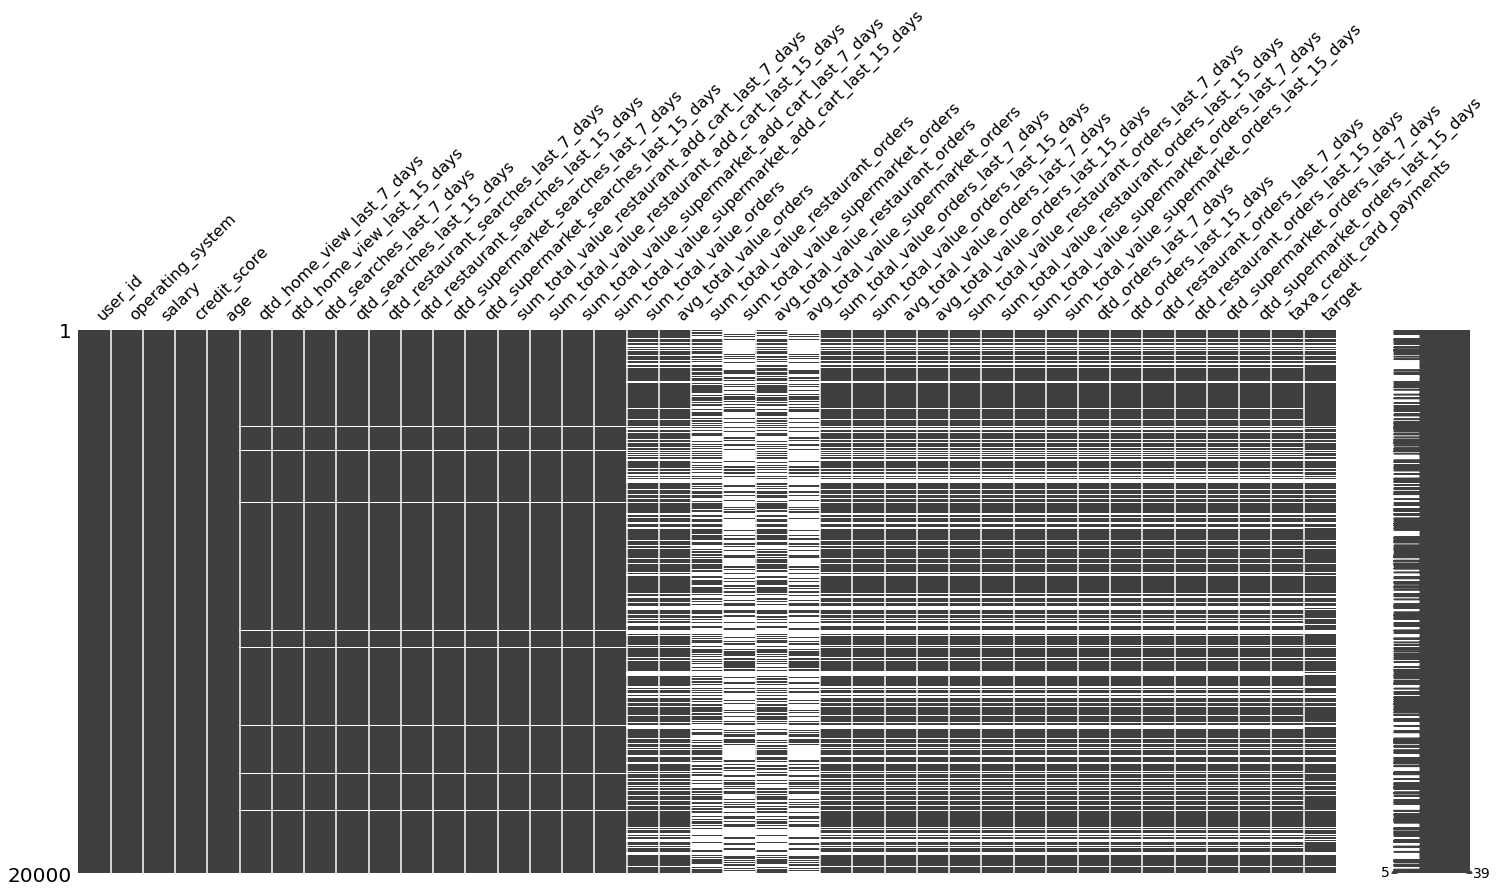

In [11]:
%matplotlib inline
msno.matrix(df.sample(frac=1));

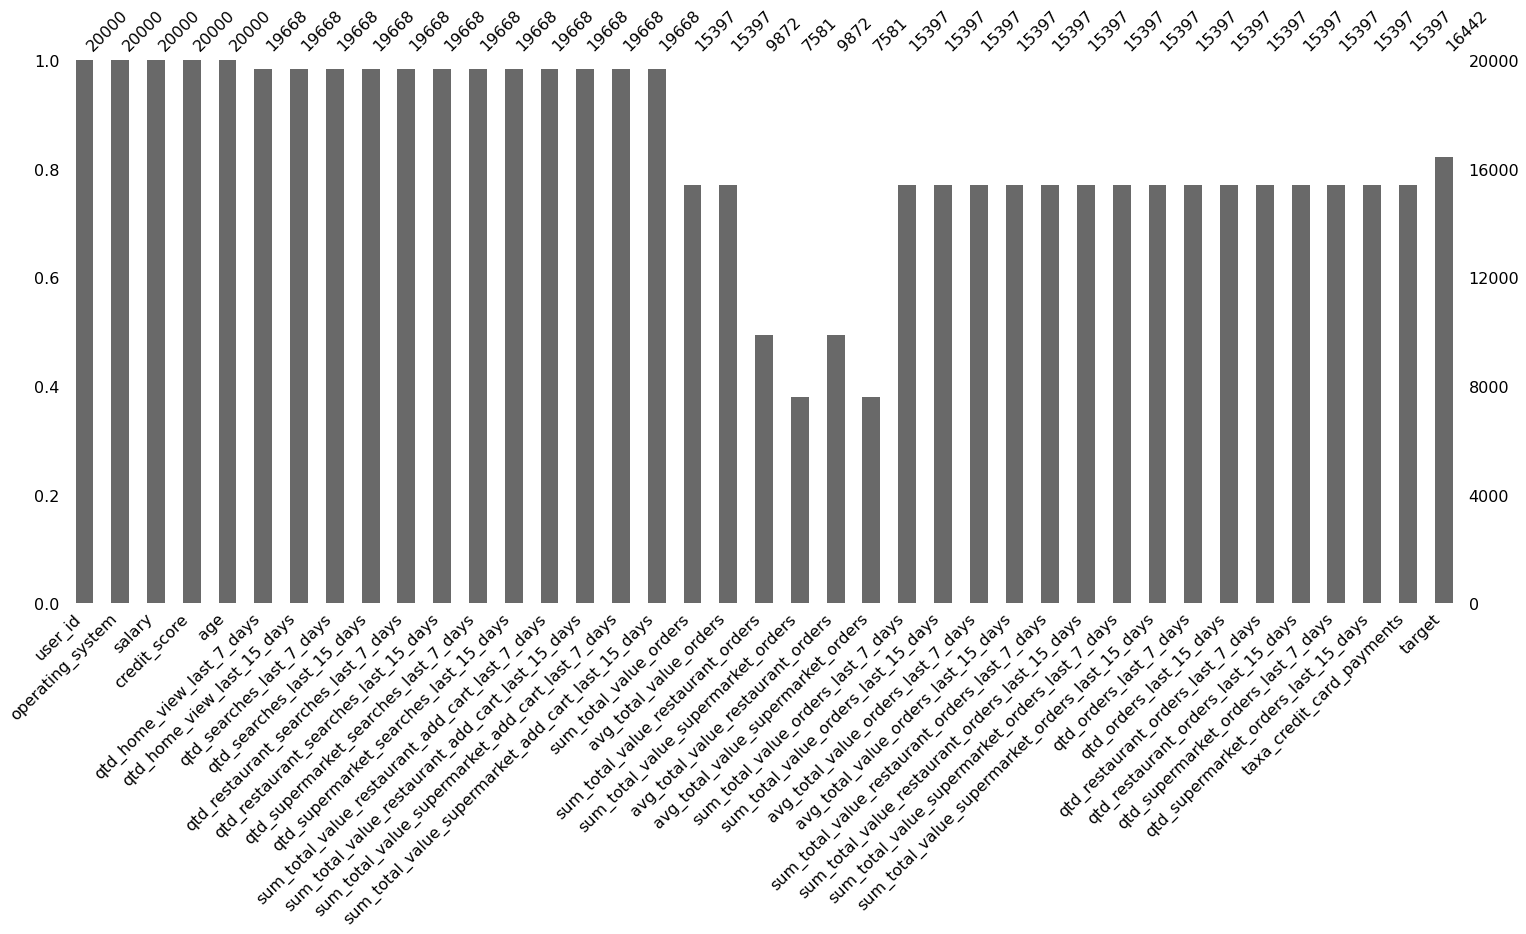

In [12]:
msno.bar(df.sample(frac=1));

In [13]:
(100 * df.isnull().sum() / df.shape[0]) 

user_id                                               0.000
operating_system                                      0.000
salary                                                0.000
credit_score                                          0.000
age                                                   0.000
qtd_home_view_last_7_days                             1.660
qtd_home_view_last_15_days                            1.660
qtd_searches_last_7_days                              1.660
qtd_searches_last_15_days                             1.660
qtd_restaurant_searches_last_7_days                   1.660
qtd_restaurant_searches_last_15_days                  1.660
qtd_supermarket_searches_last_7_days                  1.660
qtd_supermarket_searches_last_15_days                 1.660
sum_total_value_restaurant_add_cart_last_7_days       1.660
sum_total_value_restaurant_add_cart_last_15_days      1.660
sum_total_value_supermarket_add_cart_last_7_days      1.660
sum_total_value_supermarket_add_cart_las

### Preenchendo valores nulos com ' 0 ' para não atrapalhar minha bvase de dados

In [14]:
df.columns

Index(['user_id', 'operating_system', 'salary', 'credit_score', 'age',
       'qtd_home_view_last_7_days', 'qtd_home_view_last_15_days',
       'qtd_searches_last_7_days', 'qtd_searches_last_15_days',
       'qtd_restaurant_searches_last_7_days',
       'qtd_restaurant_searches_last_15_days',
       'qtd_supermarket_searches_last_7_days',
       'qtd_supermarket_searches_last_15_days',
       'sum_total_value_restaurant_add_cart_last_7_days',
       'sum_total_value_restaurant_add_cart_last_15_days',
       'sum_total_value_supermarket_add_cart_last_7_days',
       'sum_total_value_supermarket_add_cart_last_15_days',
       'sum_total_value_orders', 'avg_total_value_orders',
       'sum_total_value_restaurant_orders',
       'sum_total_value_supermarket_orders',
       'avg_total_value_restaurant_orders',
       'avg_total_value_supermarket_orders',
       'sum_total_value_orders_last_7_days',
       'sum_total_value_orders_last_15_days',
       'avg_total_value_orders_last_7_days',
  

In [15]:
COLS_TO_FILL = [
'qtd_home_view_last_7_days'    
,'qtd_home_view_last_15_days'                            
,'qtd_searches_last_7_days'                              
,'qtd_searches_last_15_days'                             
,'qtd_restaurant_searches_last_7_days'                   
,'qtd_restaurant_searches_last_15_days'                  
,'qtd_supermarket_searches_last_7_days'                  
,'qtd_supermarket_searches_last_15_days'                 
,'sum_total_value_restaurant_add_cart_last_7_days'       
,'sum_total_value_restaurant_add_cart_last_15_days'      
,'sum_total_value_supermarket_add_cart_last_7_days'      
,'sum_total_value_supermarket_add_cart_last_15_days'     
,'sum_total_value_orders'                                
,'avg_total_value_orders'                                
,'sum_total_value_restaurant_orders'                     
,'sum_total_value_supermarket_orders'                    
,'avg_total_value_restaurant_orders'                     
,'avg_total_value_supermarket_orders'                    
,'sum_total_value_orders_last_7_days'                    
,'sum_total_value_orders_last_15_days'                   
,'avg_total_value_orders_last_7_days'                    
,'avg_total_value_orders_last_15_days'                   
,'sum_total_value_restaurant_orders_last_7_days'         
,'sum_total_value_restaurant_orders_last_15_days'        
,'sum_total_value_supermarket_orders_last_7_days'        
,'sum_total_value_supermarket_orders_last_15_days'       
,'qtd_orders_last_7_days'                                
,'qtd_orders_last_15_days'                               
,'qtd_restaurant_orders_last_7_days'                     
,'qtd_restaurant_orders_last_15_days'                    
,'qtd_supermarket_orders_last_7_days'                    
,'qtd_supermarket_orders_last_15_days'                   
,'taxa_credit_card_payments'                             
,'target'                                                
]

In [16]:
df['taxa_credit_card_payments'].fillna(df['taxa_credit_card_payments'].dropna().mean(), inplace=True)

In [17]:
df.fillna(0, inplace=True)

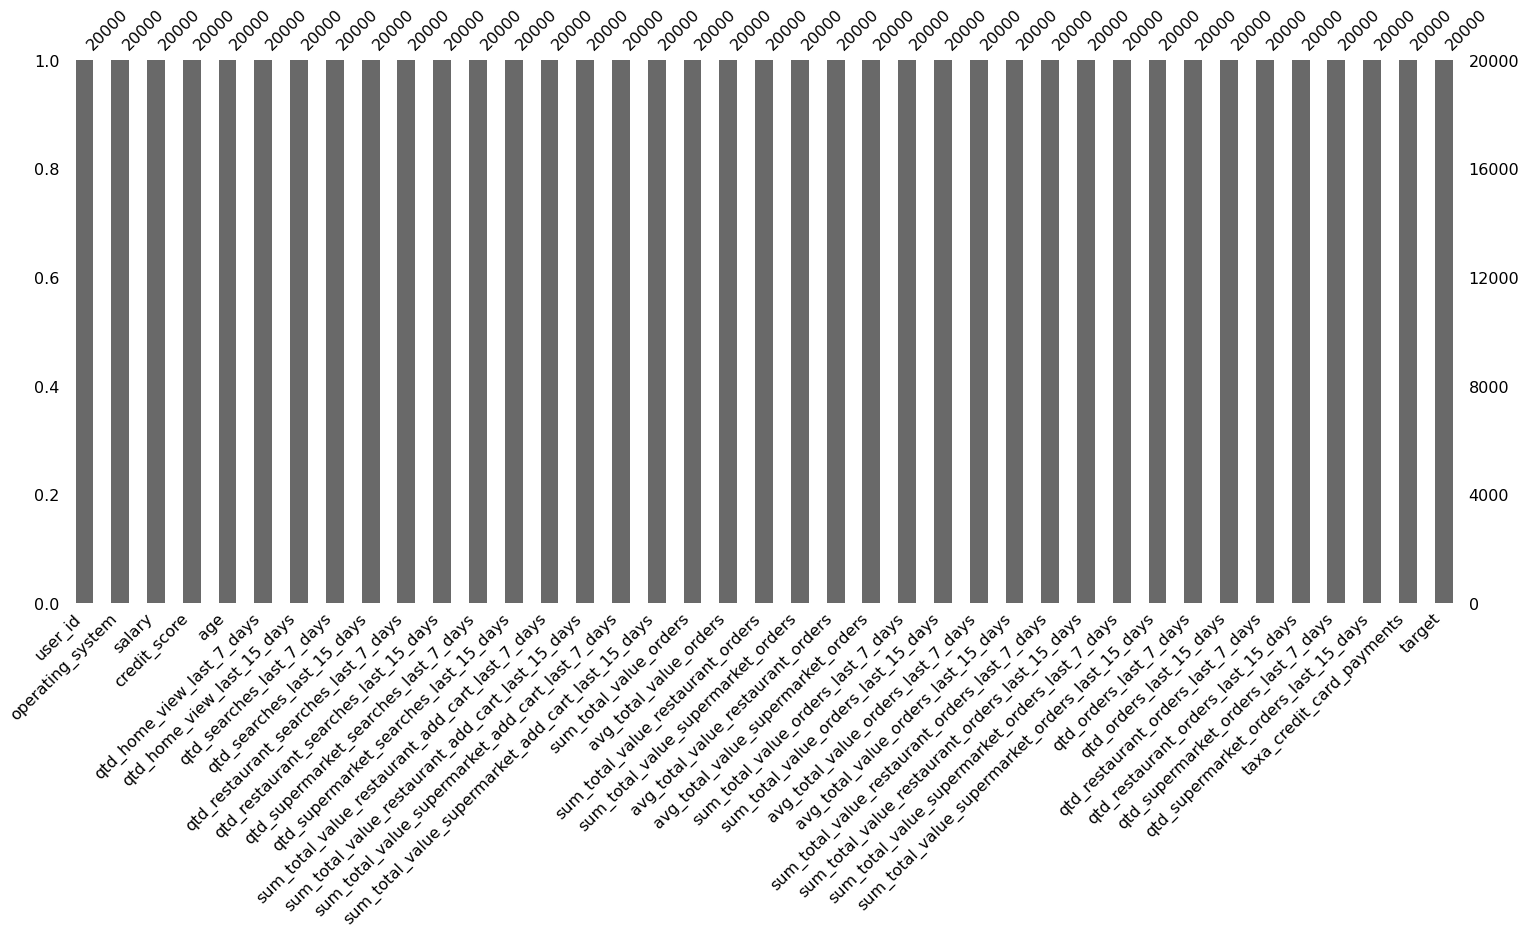

In [18]:
msno.bar(df.sample(frac=1));

### Não temos mais dados nulos

## Tratamento das variaveis categóricas

In [19]:
df = pd.get_dummies(df)

In [20]:
df.iloc[:,-2:].head()

,operating_system_android,operating_system_ios
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1


# Estatística do dados

## Análise descritiva

In [21]:
df.describe()

,user_id,salary,credit_score,age,qtd_home_view_last_7_days,qtd_home_view_last_15_days,qtd_searches_last_7_days,qtd_searches_last_15_days,qtd_restaurant_searches_last_7_days,qtd_restaurant_searches_last_15_days,qtd_supermarket_searches_last_7_days,qtd_supermarket_searches_last_15_days,sum_total_value_restaurant_add_cart_last_7_days,sum_total_value_restaurant_add_cart_last_15_days,sum_total_value_supermarket_add_cart_last_7_days,sum_total_value_supermarket_add_cart_last_15_days,sum_total_value_orders,avg_total_value_orders,sum_total_value_restaurant_orders,sum_total_value_supermarket_orders,avg_total_value_restaurant_orders,avg_total_value_supermarket_orders,sum_total_value_orders_last_7_days,sum_total_value_orders_last_15_days,avg_total_value_orders_last_7_days,avg_total_value_orders_last_15_days,sum_total_value_restaurant_orders_last_7_days,sum_total_value_restaurant_orders_last_15_days,sum_total_value_supermarket_orders_last_7_days,sum_total_value_supermarket_orders_last_15_days,qtd_orders_last_7_days,qtd_orders_last_15_days,qtd_restaurant_orders_last_7_days,qtd_restaurant_orders_last_15_days,qtd_supermarket_orders_last_7_days,qtd_supermarket_orders_last_15_days,taxa_credit_card_payments,target,operating_system_android,operating_system_ios
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,3686.973267,614.450550,39.744350,2.097400,4.131250,5.944450,11.448050,3.245300,6.232450,1.359400,2.625850,157.471767,309.863688,194.238809,389.747987,855.283119,125.896642,342.865267,448.928766,66.878756,113.244087,301.725425,601.617431,43.872812,88.786541,121.680798,239.996966,158.036898,317.326482,2.124750,4.175200,1.119500,2.198350,0.638500,1.249650,0.721656,0.769300,0.696200,0.303800
std,5773.647028,3703.606235,71.920792,17.233585,2.703031,5.170615,4.929055,9.190355,3.536616,6.543352,2.267816,4.241929,351.768185,673.293654,493.866444,924.149975,1480.337822,199.969589,813.293246,1118.235065,150.511552,253.947125,568.677373,1069.473294,94.806327,160.868378,307.254976,581.899897,439.939269,815.040992,2.872629,5.393363,2.099295,3.915274,1.416904,2.662439,0.230798,0.421291,0.459909,0.459909
min,1.000000,0.000000,424.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5000.750000,1066.070000,559.000000,25.000000,0.000000,0.000000,2.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.287500,10.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,1.000000,0.000000,0.000000
50%,10000.500000,2608.065000,601.000000,38.000000,1.000000,2.000000,5.000000,9.000000,2.000000,4.000000,0.000000,0.000000,0.000000,9.795000,0.000000,0.000000,296.000000,68.400000,0.000000,0.000000,0.000000,0.000000,72.000000,192.000000,14.285714,42.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.721656,1.000000,1.000000,0.000000
75%,15000.250000,5143.165000,663.000000,52.000000,3.000000,6.000000,8.000000,16.000000,5.000000,9.000000,2.000000,4.000000,161.992500,337.270000,144.000000,361.010000,1020.467500,160.686667,327.552500,378.000000,77.130000,135.831250,349.067500,702.020000,52.806273,110.9

Algumas Descobertas após a analise descritiva:


*   O salario médio de nossos usuários é por volta de $ 3.686 mil
*   A idade média nos nossos usuários arredondando é 40 anos
*   Os usuários fazem em média 6 buscas por semana e 11,6 a 12 a cada 2 semanas
*   Restaurante é a vertical mais buscada, com média de 3.3 buscas contra 1.4 buscas semanais em supermercados

## Probabilidade de um usuário realizar pelo menos um pedido dentro de uma semana

Essa probabilidade pode ser calculada considerando o nosso **target** que representa exatamente os usuários que realizaram pelo menos uma compra dentro da ultima semana

In [22]:
df['target'].mean()

0.7693

Nossos usuários tem probabilidade de 93% de realizar uma compra em 1 semana

## Utilizando Percentis para analisar a quantidade de pedidos realizados

In [23]:
df['qtd_orders_last_7_days'].describe(percentiles=[.25, .50, .75, .9])

count    20000.000000
mean         2.124750
std          2.872629
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
90%          6.000000
max         24.000000
Name: qtd_orders_last_7_days, dtype: float64

Temos 50% dos usuários com 2 pedidos considerando 7 dias. mas se olharmos a média temos 2.7599 quase 2.76 pedidos em 7 dias a média não é tão afetada pelos usuários que fazem muitos pedidos.
 A mediana é um pouco diferente e representa um pouco melhor a quantidade de pedido da maioria

## Verificando os outliers

utilizando Elliptic Envelope 

In [24]:
elpenv = EllipticEnvelope(random_state=42, contamination=0.05)


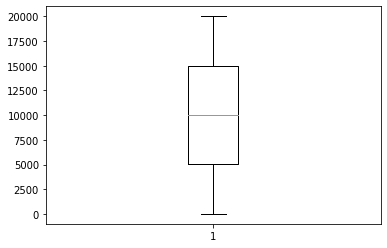

In [25]:
plt.boxplot(df['user_id'])
plt.show()

In [26]:

# Returns 1 of inliers, -1 for outliers
df['outlier'] = elpenv.fit_predict(df[[i for i in df.columns if i not in ('user_id')]])

In [27]:
df

,user_id,salary,credit_score,age,qtd_home_view_last_7_days,qtd_home_view_last_15_days,qtd_searches_last_7_days,qtd_searches_last_15_days,qtd_restaurant_searches_last_7_days,qtd_restaurant_searches_last_15_days,qtd_supermarket_searches_last_7_days,qtd_supermarket_searches_last_15_days,sum_total_value_restaurant_add_cart_last_7_days,sum_total_value_restaurant_add_cart_last_15_days,sum_total_value_supermarket_add_cart_last_7_days,sum_total_value_supermarket_add_cart_last_15_days,sum_total_value_orders,avg_total_value_orders,sum_total_value_restaurant_orders,sum_total_value_supermarket_orders,avg_total_value_restaurant_orders,avg_total_value_supermarket_orders,sum_total_value_orders_last_7_days,sum_total_value_orders_last_15_days,avg_total_value_orders_last_7_days,avg_total_value_orders_last_15_days,sum_total_value_restaurant_orders_last_7_days,sum_total_value_restaurant_orders_last_15_days,sum_total_value_supermarket_orders_last_7_days,sum_total_value_supermarket_orders_last_15_days,qtd_orders_last_7_days,qtd_orders_last_15_days,qtd_restaurant_orders_last_7_days,qtd_restaurant_orders_last_15_days,qtd_supermarket_orders_last_7_days,qtd_supermarket_orders_last_15_days,taxa_credit_card_payments,target,operating_system_android,operating_system_ios,outlier
0,8792,4682.76,781,47,4.0,12.0,8.0,15.0,2.0,3.0,1.0,4.0,84.01,366.20,11.00,208.17,2893.98,55.653462,533.99,284.00,16.181515,56.800000,1067.01,1971.89,20.519423,37.920962,84.01,366.20,11.00,208.17,15.0,38.0,10.0,26.0,2.0,4.0,0.769231,1.0,1,0,1
1,15536,2675.78,551,47,5.0,12.0,23.0,45.0,7.0,18.0,9.0,15.0,212.00,406.34,901.00,969.58,1363.54,29.011489,504.90,750.64,22.950000,35.744762,752.96,1014.13,16.020426,21.577234,182.32,341.68,570.64,639.22,13.0,27.0,8.0,15.0,5.0,11.0,0.851064,1.0,0,1,1
2,16944,3278.60,814,47,6.0,14.0,19.0,45.0,7.0,16.0,8.0,22.0,619.99,880.73,1530.01,1742.91,2754.75,45.159836,946.98,1799.77,31.566000,64.277500,1759.35,2192.71,28.841803,35.946066,505.18,733.32,1248.17,1451.39,17.0,39.0,8.0,19.0,8.0,17.0,0.786885,1.0,0,1,1
3,19636,5209.68,606,47,0.0,0.0,12.0,16.0,10.0,14.0,0.0,0.0,986.00,2134.63,0.00,28.00,3008.99,158.367895,2980.99,28.00,165.610556,28.000000,986.00,2162.63,51.894737,113.822632,986.00,2134.63,0.00,28.00,9.0,16.0,9.0,15.0,0.0,1.0,0.736842,1.0,0,1,1
4,19294,126.51,642,47,7.0,16.0,10.0,17.0,5.0,10.0,3.0,3.0,558.99,889.67,1240.00,2335.11,4149.73,125.749394,1130.17,3019.56,45.206800,377.445000,1798.99,2700.58,54.514848,81.835758,558.99,844.58,1240.00,1856.00,13.0,22.0,10.0,18.0,3.0,4.0,0.818182,1.0,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,9397,512.36,540,33,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,700.00,1420.00,0.00,0.00,1940.00,107.777778,1940.00,0.00,107.777778,0.000000,700.00,1420.00,38.888889,78.888889,700.00,1420.00,0.00,0.00,6.0,13.0,6.0,13.0,0.0,0.0,0.722222,1.0,0,1,1
19996,10943,1776.13,620,33,0.0,0.0,11.0,19.0,10.0,17.0,1.0,2.0,450.00,617.62,0.00,0.00,1656.00,92.000000,802.00,854.00,53.466667,284.666667,450.00,617.62,25.000000,34.312222,450.00,617.62,0.00,0.00,11.0,13.0,11.0,13.0,0.0,0.0,0.777778,1.0,1,0,1
19997,17735,10739.01,756,33,12.0,13.0,23.0,39.0,20.0,33.0,0.0,0.0,1692.00,1802.96,0.00,0.00,1791.27,89.563500,1621.26,0.00,101.328750,0.000000,1490.57,1712.40,74.528500,85.620000,1490.57,1586.74,0.00,0.00,5.0,16.0,5.0,13.0,0.0,0.0,0.750000,1.0,1,0,1
19998,17417,7889.10,641,40,3.0,8.0,2.0,6.0,1.0,2.0,0.0,3.0,210.00,427.24,924.00,1590.42,3036.58,112.465926,483.58,2553.00,30.223750,232.090909,1111.89,1941.24,41.181111,71.897778,187.89,350.82,924.00,1590.42,9.0,20.0,6.0,13.0,3.0,7.0,0.777778,1.0,1,0,1


In [28]:
df.outlier.value_counts(normalize=True)

 1    0.95
-1    0.05
Name: outlier, dtype: float64

In [29]:
df_clean = df.loc[df.outlier == 1].drop('outlier', axis=1)

In [30]:
df_clean.shape

(19000, 40)

In [31]:
df_clean.target.mean()

0.758

apos remover outliers temos agora apenas 19 mil linhas

### correlação entre as variáveis


In [32]:
df_clean.corr()

,user_id,salary,credit_score,age,qtd_home_view_last_7_days,qtd_home_view_last_15_days,qtd_searches_last_7_days,qtd_searches_last_15_days,qtd_restaurant_searches_last_7_days,qtd_restaurant_searches_last_15_days,qtd_supermarket_searches_last_7_days,qtd_supermarket_searches_last_15_days,sum_total_value_restaurant_add_cart_last_7_days,sum_total_value_restaurant_add_cart_last_15_days,sum_total_value_supermarket_add_cart_last_7_days,sum_total_value_supermarket_add_cart_last_15_days,sum_total_value_orders,avg_total_value_orders,sum_total_value_restaurant_orders,sum_total_value_supermarket_orders,avg_total_value_restaurant_orders,avg_total_value_supermarket_orders,sum_total_value_orders_last_7_days,sum_total_value_orders_last_15_days,avg_total_value_orders_last_7_days,avg_total_value_orders_last_15_days,sum_total_value_restaurant_orders_last_7_days,sum_total_value_restaurant_orders_last_15_days,sum_total_value_supermarket_orders_last_7_days,sum_total_value_supermarket_orders_last_15_days,qtd_orders_last_7_days,qtd_orders_last_15_days,qtd_restaurant_orders_last_7_days,qtd_restaurant_orders_last_15_days,qtd_supermarket_orders_last_7_days,qtd_supermarket_orders_last_15_days,taxa_credit_card_payments,target,operating_system_android,operating_system_ios
user_id,1.000000,0.001131,0.001843,-0.000443,-0.072788,-0.099402,-0.001080,-0.002051,0.004744,0.000021,-0.010115,-0.007571,0.000421,0.000195,0.004231,-0.001914,-0.002261,-0.003493,-0.001218,-0.003611,-0.000592,-0.013249,0.007294,0.002082,0.006347,0.000954,0.001827,0.001797,0.007776,0.000452,0.007920,0.009024,0.006096,0.004606,-0.002000,-0.001202,0.019971,0.005420,0.001246,-0.001246
salary,0.001131,1.000000,0.345256,-0.000800,0.166927,0.160441,0.176274,0.179437,0.131831,0.133073,0.115945,0.118058,0.081501,0.084132,0.127235,0.142887,0.178647,0.071296,0.109993,0.154299,0.045791,0.106713,0.163568,0.175511,0.060619,0.063085,0.102262,0.106939,0.132566,0.150903,0.163208,0.169674,0.110563,0.110579,0.136335,0.145621,0.078821,0.092781,-0.072675,0.072675
credit_score,0.001843,0.345256,1.000000,-0.002757,0.296277,0.295623,0.352137,0.358974,0.271082,0.277248,0.225927,0.229756,0.158950,0.169173,0.251766,0.288333,0.359315,0.149823,0.213192,0.317672,0.085968,0.213747,0.322267,0.346079,0.114811,0.128170,0.195246,0.206258,0.264624,0.301592,0.337379,0.350795,0.215605,0.222814,0.290156,0.304233,0.165783,0.190749,-0.146561,0.146561
age,-0.000443,-0.000800,-0.002757,1.000000,-0.011878,-0.013046,-0.003700,-0.003847,-0.006697,-0.006557,0.000851,0.003777,0.001705,-0.000208,-0.006820,-0.006103,-0.000617,0.005412,0.000891,-0.000392,0.011503,-0.000948,-0.004243,-0.003787,0.006890,0.004638,0.003979,0.002570,-0.008111,-0.007161,-0.005576,-0.001979,-0.003640,-0.000808,-0.005835,-0.005781,0.004146,-0.004877,0.002063,-0.002063
qtd_home_view_last_7_days,-0.072788,0.166927,0.296277,-0.011878,1.000000,0.920859,0.158080,0.163112,0.120589,0.126593,0.098151,0.100277,0.069160,0.067390,0.105902,0.121531,0.154603,0.055796,0.089421,0.138502,0.031763,0.084798,0.139223,0.146107,0.043987,0.042137,0.085815,0.085557,0.111244,0.127191,0.148555,0.156518,0.099430,0.101951,0.120069,0.127333,0.064977,0.077901,-0.048733,0.048733
qtd_home_view_last_15_days,-0.099402,0.160441,0.295623,-0.013046,0.920859,1.000000,0.156523,0.162023,0.122730,0.129080,0.098646,0.100507,0.070353,0.070292,0.104013,0.119160,0.155786,0.059594,0.094038,0.135406,0.038215,0.085631,0.137189,0.145373,0.042694,0.041883,0.087257,0.087844,0.107316,0.123465,0.149638,0.155632,0.103820,0.104608,0.116514,0.124362,0.064491,0.079432,-0.040415,0.040415
qtd_searches_last_7_days,-0.001080,0.176274,0.352137,-0.003700,0.158080,0.156523,1.000000,0.924896,0.799376,0.733556,0.526926,0.494936,0.247966,0.258098,0.304898,0.336194,0.425199,0.160576,0.266231,0.343396,0.129273,0.225686,0.394416,0.416779,0.131718,0.144110,0.249172,0.262554,0.300010,0.331556,0.452056,0.472017,0.289779,0.309413,0.343289,0.354125,0.071476,0.303051,-0.064391,0.064391
qtd_searches_last_15_days,-0.002051,0.179437,0.35897

In [33]:
def remove_variaveis_correlacionadas(x, threshold):
 
    # calcula a matriz de correlacao
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # itera sobre a matriz e compara as correlacoes
    for a in iters:
        for j in range(a+1):
            item = corr_matrix.iloc[j:(j+1), (a+1):(a+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # se a correlacao é maior que o threshold
            if val >= threshold:
                # Print da correlacao e das variaveis
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop uma do par de variaveis correlacionadas
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

In [34]:
df_clean_2 = remove_variaveis_correlacionadas(df_clean, 0.7)

qtd_home_view_last_15_days | qtd_home_view_last_7_days | 0.92
qtd_searches_last_15_days | qtd_searches_last_7_days | 0.92
qtd_restaurant_searches_last_7_days | qtd_searches_last_7_days | 0.8
qtd_restaurant_searches_last_7_days | qtd_searches_last_15_days | 0.73
qtd_restaurant_searches_last_15_days | qtd_searches_last_7_days | 0.73
qtd_restaurant_searches_last_15_days | qtd_searches_last_15_days | 0.8
qtd_restaurant_searches_last_15_days | qtd_restaurant_searches_last_7_days | 0.91
qtd_supermarket_searches_last_15_days | qtd_supermarket_searches_last_7_days | 0.93
sum_total_value_restaurant_add_cart_last_15_days | sum_total_value_restaurant_add_cart_last_7_days | 0.88
sum_total_value_supermarket_add_cart_last_15_days | sum_total_value_supermarket_add_cart_last_7_days | 0.86
sum_total_value_orders | sum_total_value_restaurant_add_cart_last_15_days | 0.71
sum_total_value_restaurant_orders | sum_total_value_restaurant_add_cart_last_7_days | 0.83
sum_total_value_restaurant_orders | sum_tota

In [35]:
df_clean_2.shape

(19000, 18)

In [40]:
df_clean_2.head()

,user_id,salary,credit_score,age,qtd_home_view_last_7_days,qtd_searches_last_7_days,qtd_supermarket_searches_last_7_days,sum_total_value_restaurant_add_cart_last_7_days,sum_total_value_supermarket_add_cart_last_7_days,avg_total_value_orders,avg_total_value_restaurant_orders,avg_total_value_supermarket_orders,avg_total_value_orders_last_7_days,qtd_orders_last_7_days,qtd_supermarket_orders_last_7_days,taxa_credit_card_payments,target,operating_system_android
0,8792,4682.76,781,47,4.0,8.0,1.0,84.01,11.00,55.653462,16.181515,56.800000,20.519423,15.0,2.0,0.769231,1.0,1
1,15536,2675.78,551,47,5.0,23.0,9.0,212.00,901.00,29.011489,22.950000,35.744762,16.020426,13.0,5.0,0.851064,1.0,0
2,16944,3278.60,814,47,6.0,19.0,8.0,619.99,1530.01,45.159836,31.566000,64.277500,28.841803,17.0,8.0,0.786885,1.0,0
3,19636,5209.68,606,47,0.0,12.0,0.0,986.00,0.00,158.367895,165.610556,28.000000,51.894737,9.0,0.0,0.736842,1.0,0
5,2572,226.20,655,47,0.0,11.0,1.0,1080.00,750.00,117.619048,71.000000,397.333333,80.714286,13.0,1.0,0.904762,1.0,0


In [36]:
df_clean.shape

(19000, 40)

In [37]:
df.shape

(20000, 41)

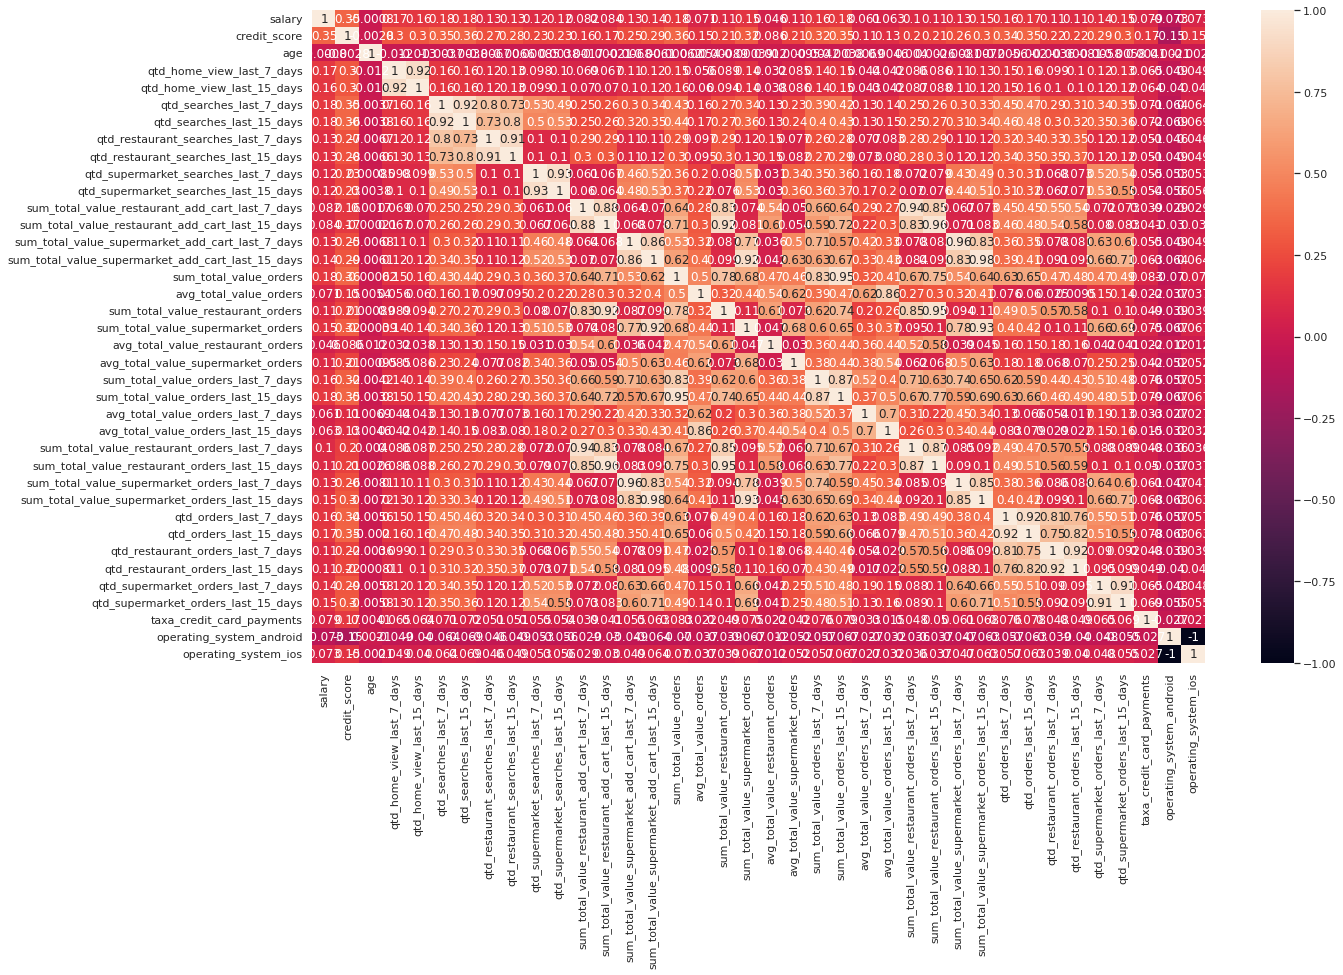

In [38]:
sns.set(rc={'figure.figsize':(20,12)})
sns.heatmap(df_clean.drop(['user_id', 'target' ], axis=1).corr(), annot=True);

Plotando o set de variável sem as correlações

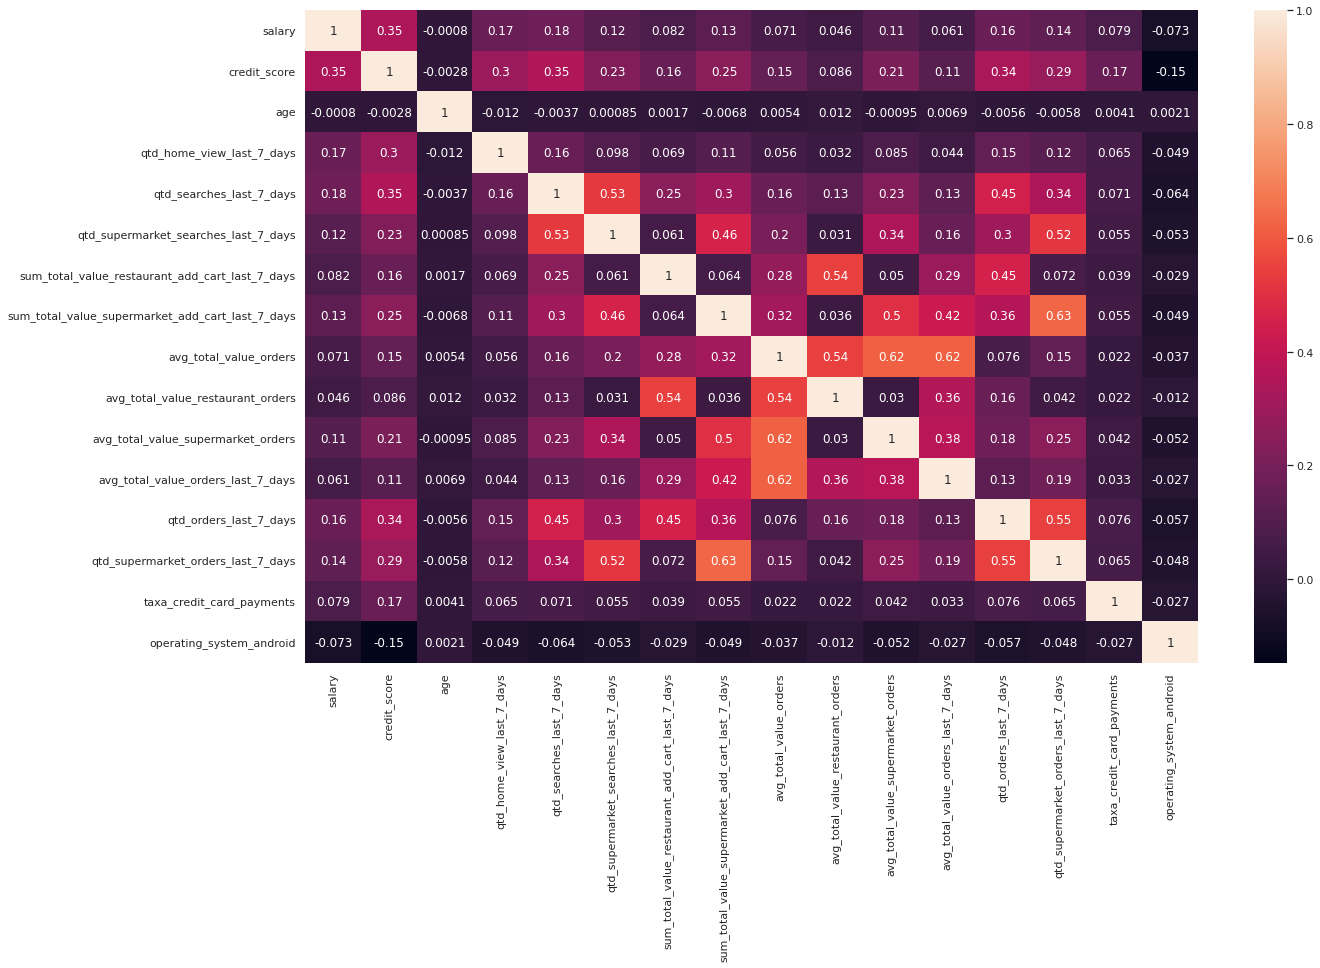

In [39]:
sns.set(rc={'figure.figsize':(20,12)})
sns.heatmap(df_clean_2.drop(['user_id', 'target' ], axis=1).corr(), annot=True);

## Idade do usuário

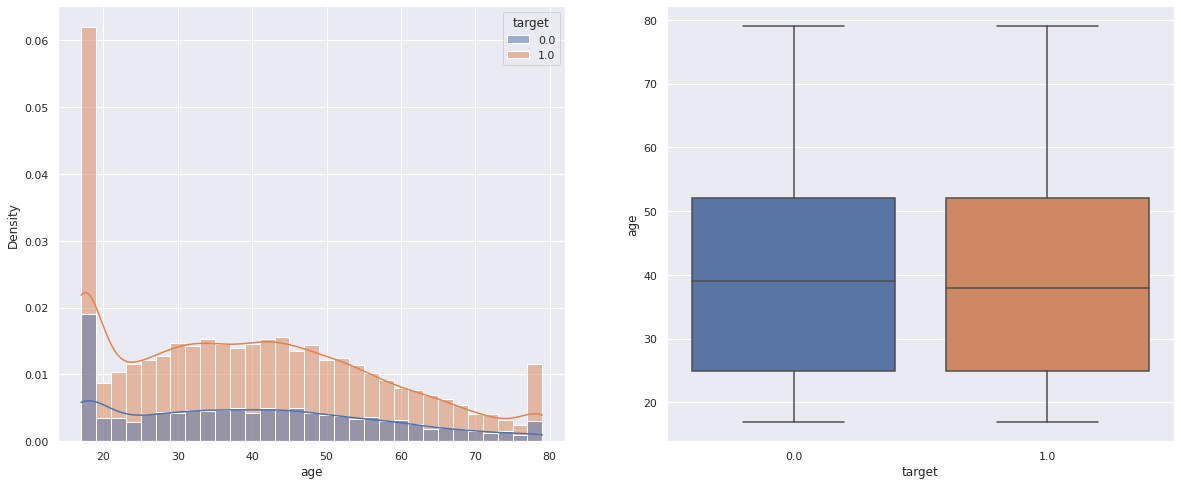

In [44]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="age", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="age", x="target", ax=axs[1]);


## Salário

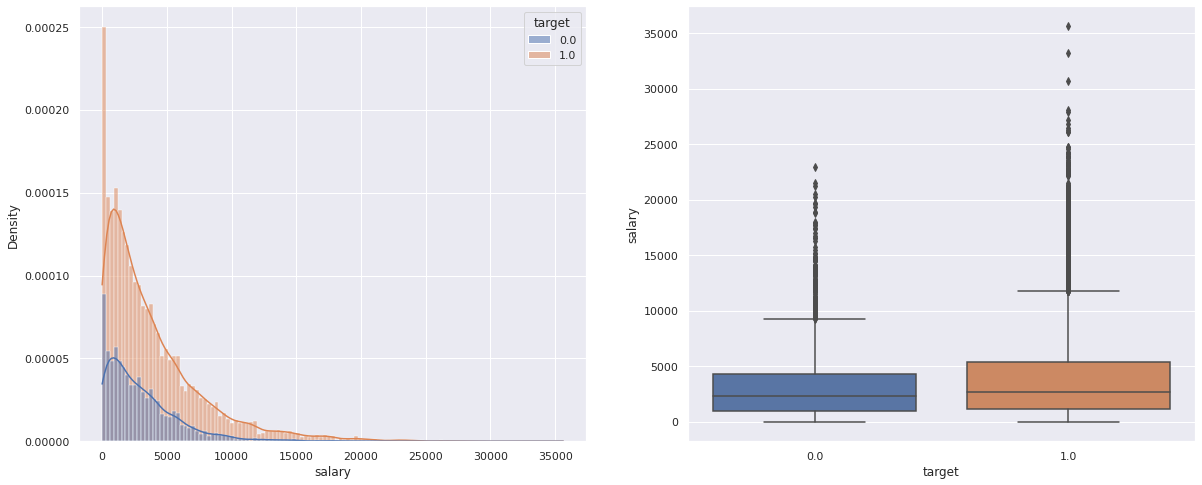

In [45]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="salary", hue="target", stat="density",  kde=True, ax=axs[0]) ;
sns.boxplot(data=df_clean_2, y="salary", x="target", ax=axs[1]);

## Score de crédito

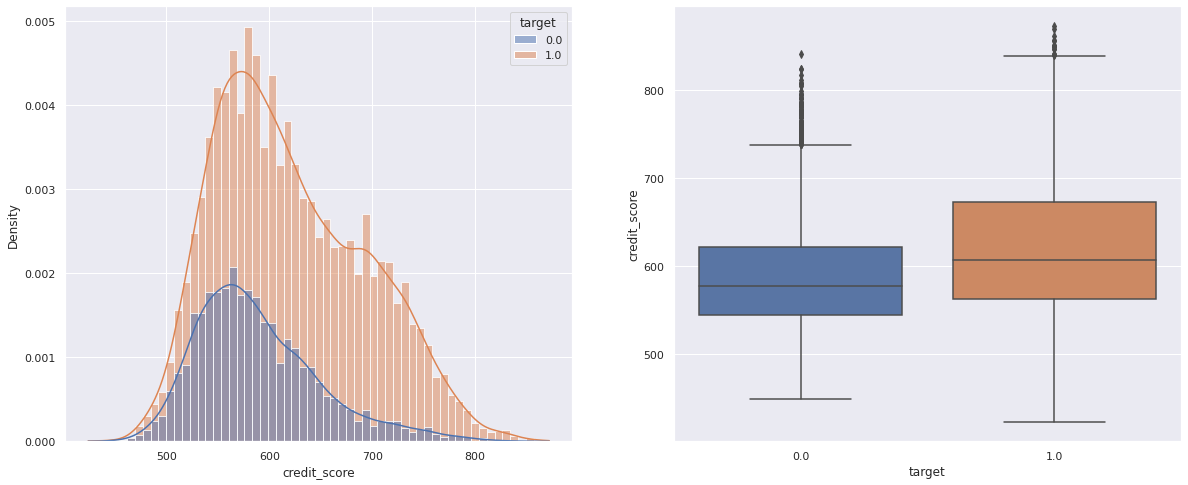

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="credit_score", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="credit_score", x="target", ax=axs[1]);

## Quantidade de visualizações de home page nos últimos 7 dias

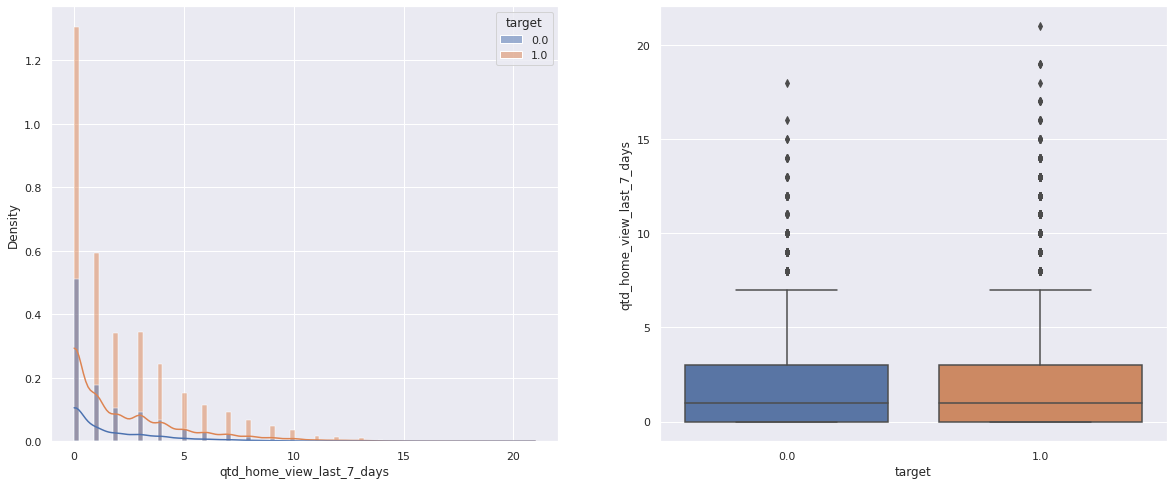

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="qtd_home_view_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="qtd_home_view_last_7_days", x="target", ax=axs[1]);

## Quantidade de buscas feitas nos últimos 7 dias

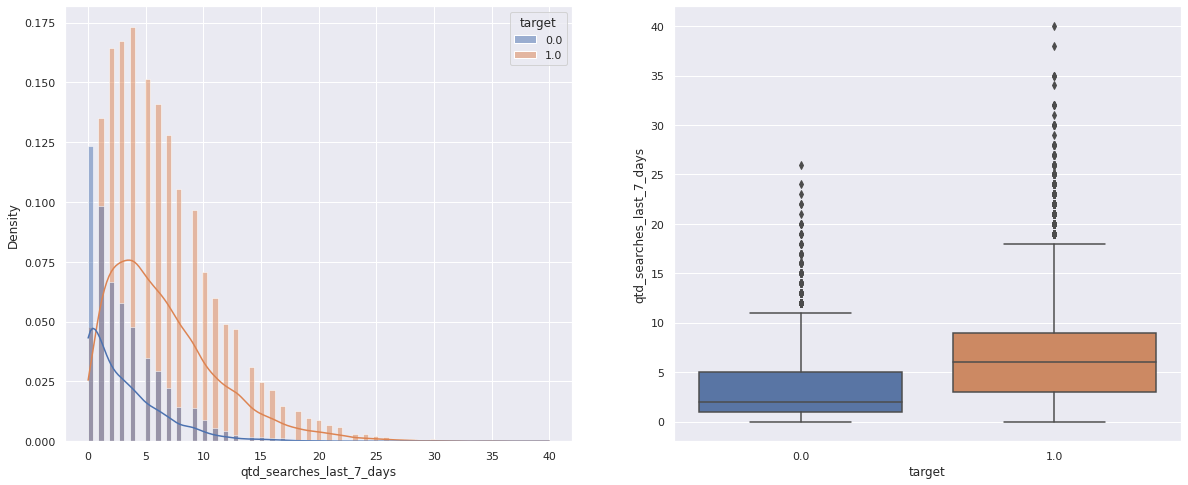

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="qtd_searches_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="qtd_searches_last_7_days", x="target", ax=axs[1]);

## Quantidade de buscas feitas em supermercados nos últimos 7 dias

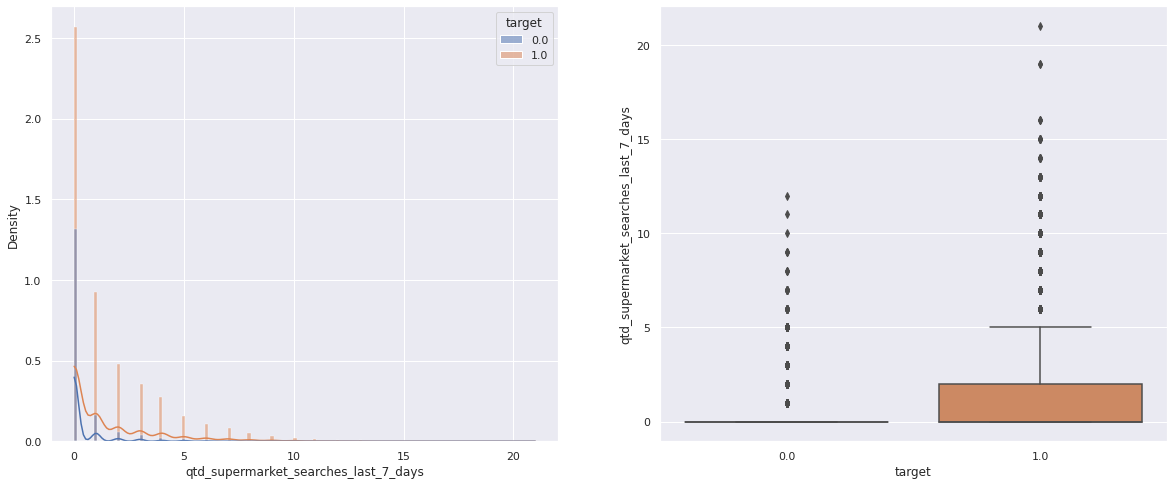

In [49]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="qtd_supermarket_searches_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="qtd_supermarket_searches_last_7_days", x="target", ax=axs[1]);


## Soma do valor total adicionado ao carrinho em restaurantes nos últimos 7 dias

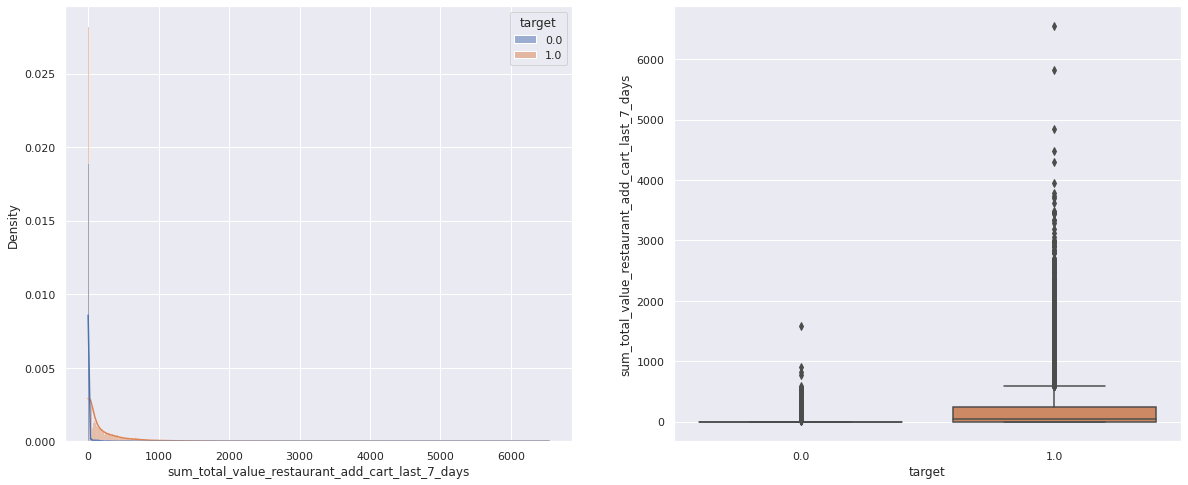

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="sum_total_value_restaurant_add_cart_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="sum_total_value_restaurant_add_cart_last_7_days", x="target", ax=axs[1]);

## Soma do valor total adicionado ao carrinho em supermercados nos últimos 7 dias

Existe uma diferença entre o valor de coisas adicionadas no carrinho em supermercados por usuários que fizeram pedidos, eles adicionam coisas com maior valor

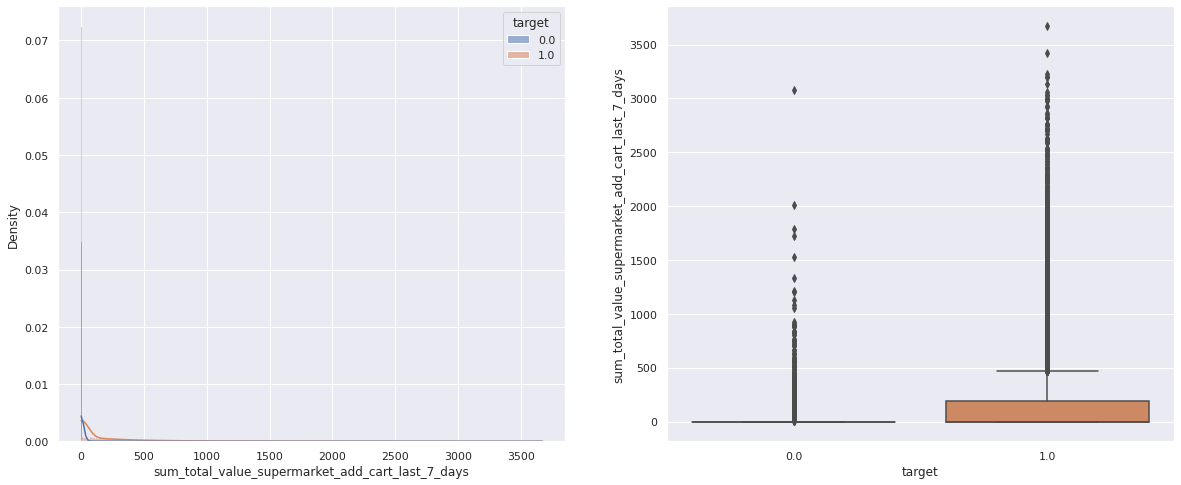

In [51]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="sum_total_value_supermarket_add_cart_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="sum_total_value_supermarket_add_cart_last_7_days", x="target", ax=axs[1]);


## Média do valor total gasto em pedidos

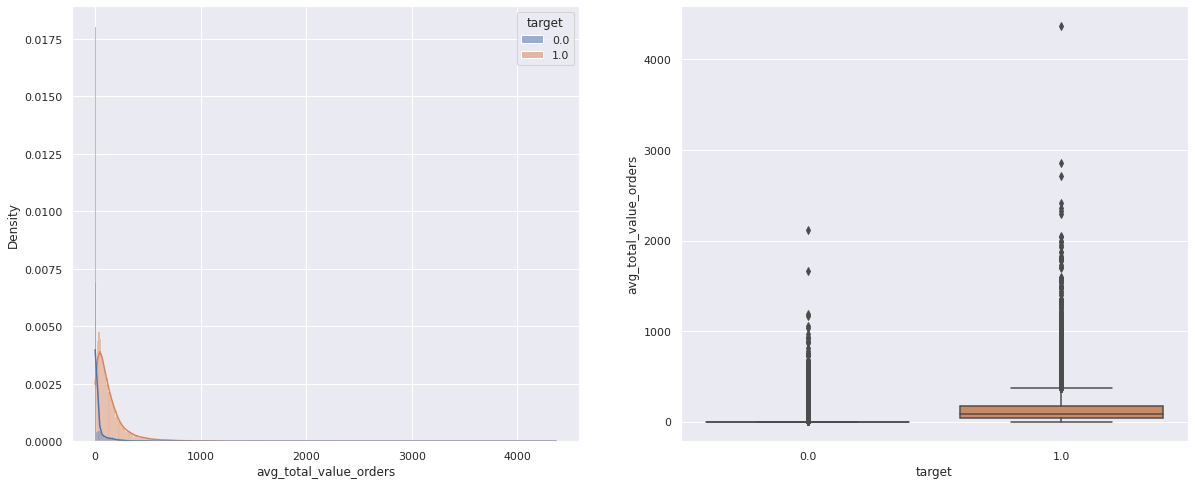

In [52]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="avg_total_value_orders", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="avg_total_value_orders", x="target", ax=axs[1]);

## Média do valor total gasto em pedidos em restaurantes

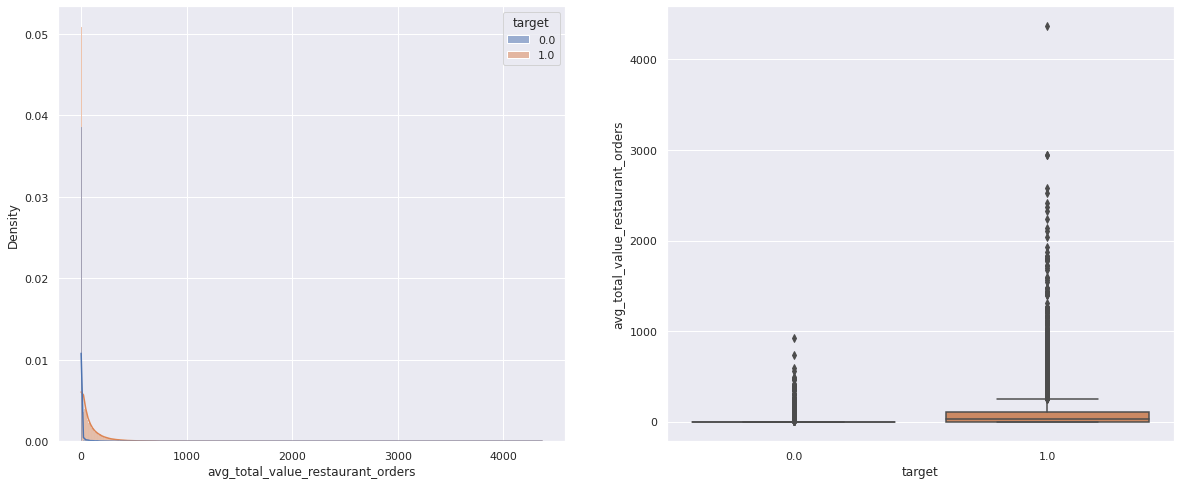

In [53]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="avg_total_value_restaurant_orders", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="avg_total_value_restaurant_orders", x="target", ax=axs[1]);


Usuários que gastaram mais no passado e restaurantes possuem uma chance maior de realizar um novo pedido dentro de uma determinada semana

## Média do valor total gasto em pedidos em supermercados

Usuários que gastaram mais no passado em supermercados possuem uma chance maior de realizar um novo pedido dentro de uma determinada semana

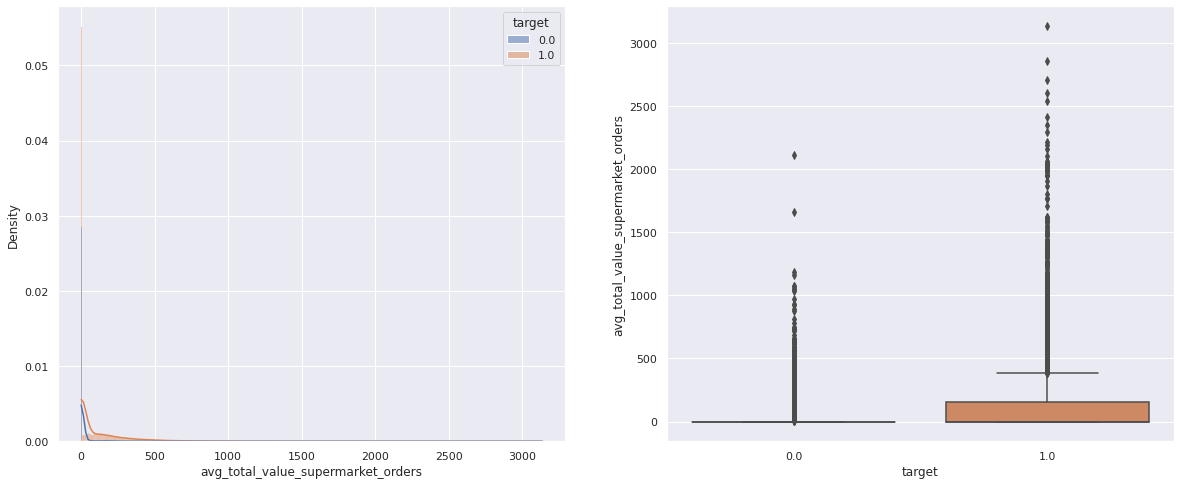

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="avg_total_value_supermarket_orders", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="avg_total_value_supermarket_orders", x="target", ax=axs[1]);


## Média do valor total gasto em pedidos nos últimos 7 dias

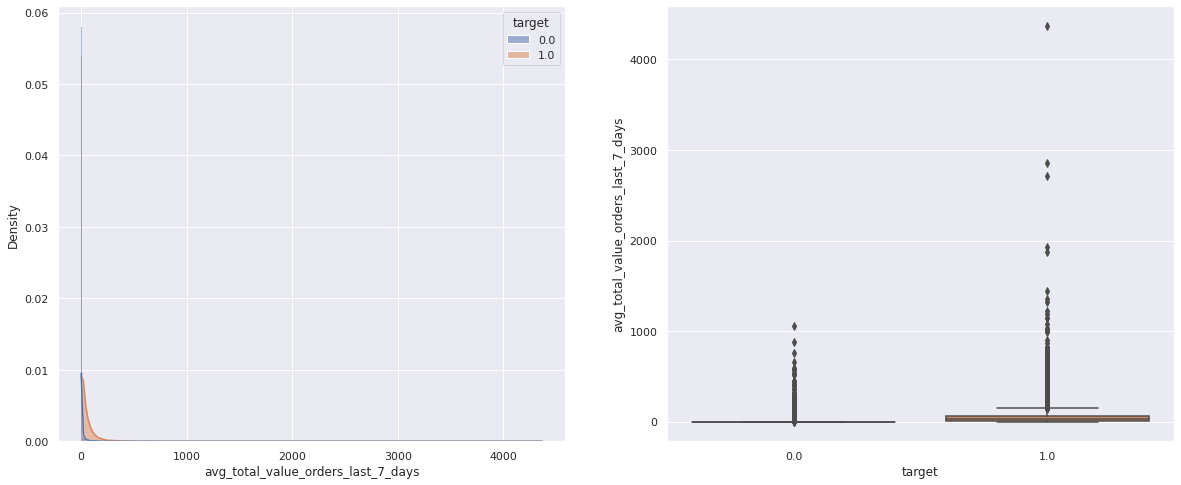

In [55]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="avg_total_value_orders_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="avg_total_value_orders_last_7_days", x="target", ax=axs[1]);


## Quantidade de pedidos nos últimos 7 dias

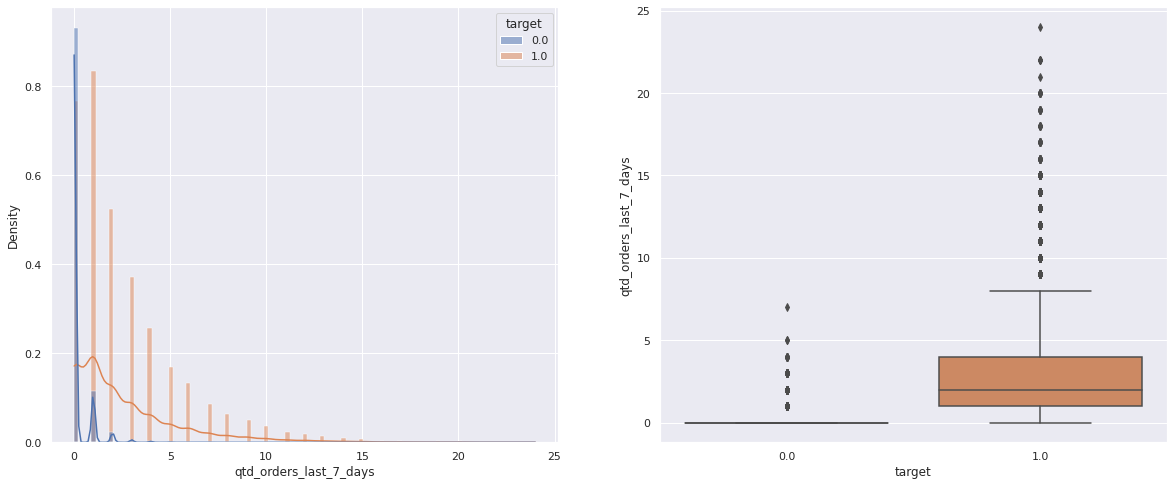

In [56]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="qtd_orders_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="qtd_orders_last_7_days", x="target", ax=axs[1]);


Usuários que fizeram um pedido ou mais nos ultimos 7 dias tem uma probabilidade maior de realizar um novo pedido

## Quantidade de pedidos em supermercados nos últimos 7 dias

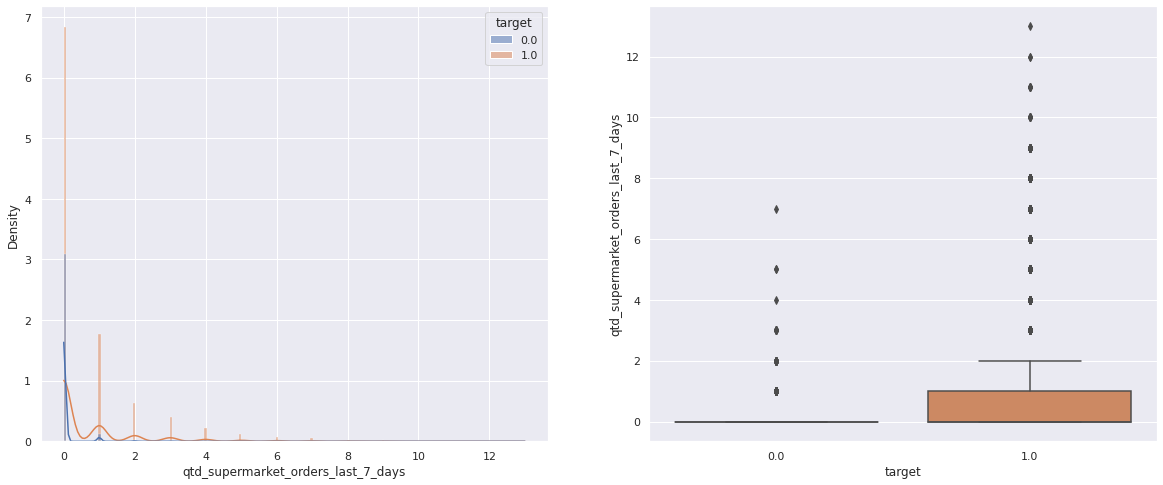

In [57]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="qtd_supermarket_orders_last_7_days", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="qtd_supermarket_orders_last_7_days", x="target", ax=axs[1]);


## Taxa de pagamentos utilizando cartão de crédito

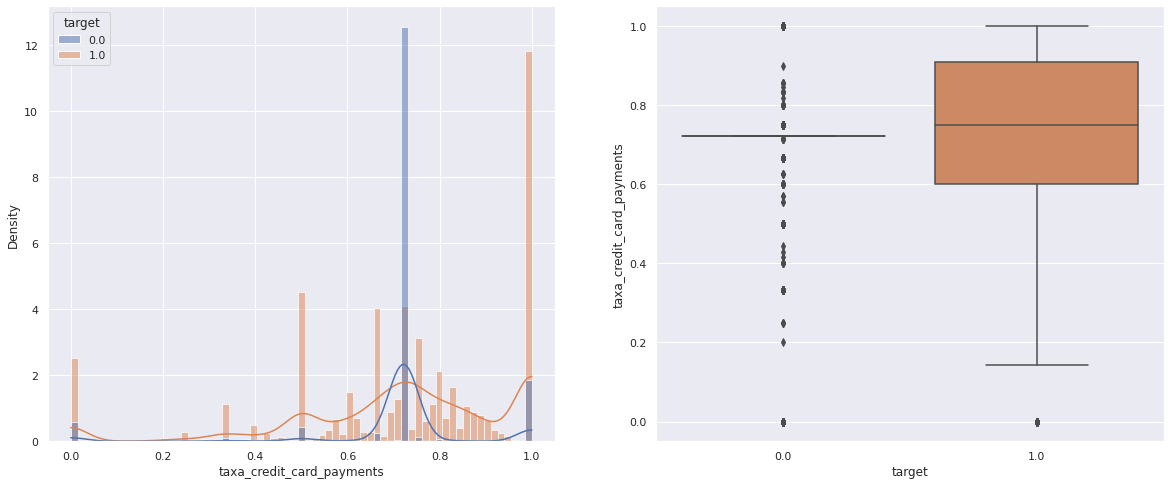

In [58]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))

sns.histplot(df_clean_2, x="taxa_credit_card_payments", hue="target", stat="density", kde=True, ax=axs[0]);
sns.boxplot(data=df_clean_2, y="taxa_credit_card_payments", x="target", ax=axs[1]);


Usuários que pagam mais com cartão de crédito possuem mais chance de realizar um novo pedido

## Salário x Quantidade de pedidos dos ultimos 7 dias

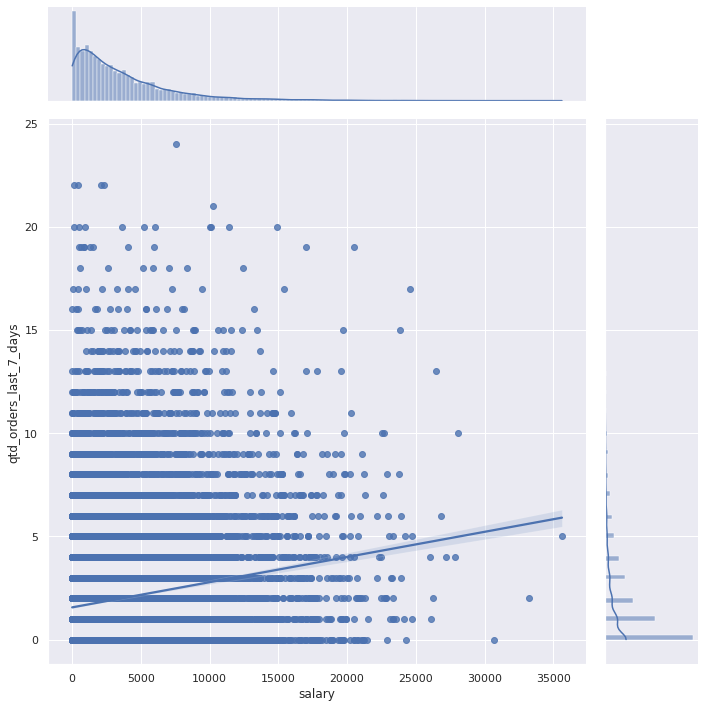

In [59]:
sns.jointplot(data=df_clean_2, x="salary", y="qtd_orders_last_7_days", kind="reg", height=10)

Existe um relação positiva, ou seja, maior o salário, maior é a tendencia em ter realizado mais pedidos no passado

## Acessos à Home page x número de pedidos 

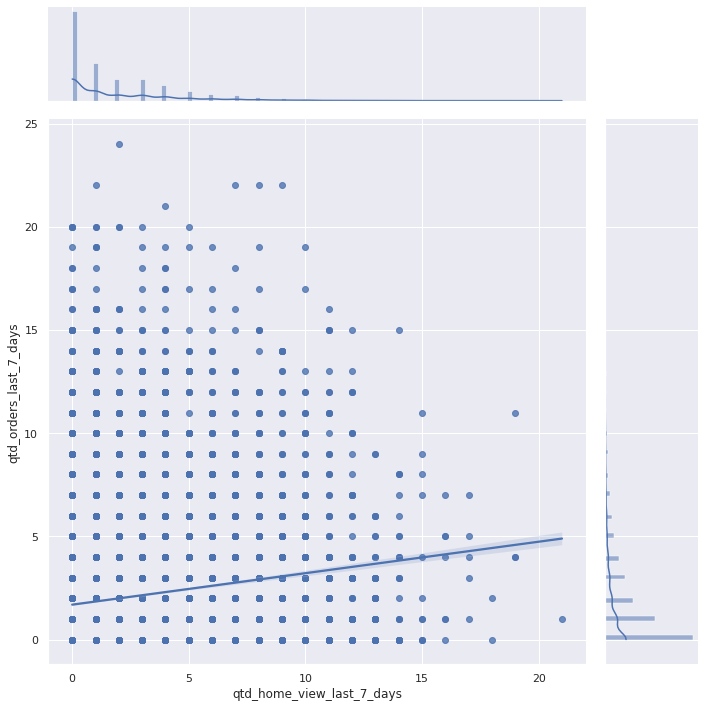

In [60]:
sns.jointplot(data=df_clean_2, x="qtd_home_view_last_7_days", y="qtd_orders_last_7_days", kind="reg", height=10)

Existe uma relação positiva também entre a quantidade de acessos a home page e a quantidade de pedidos

## Média de valor total gasto em pedidos x idade

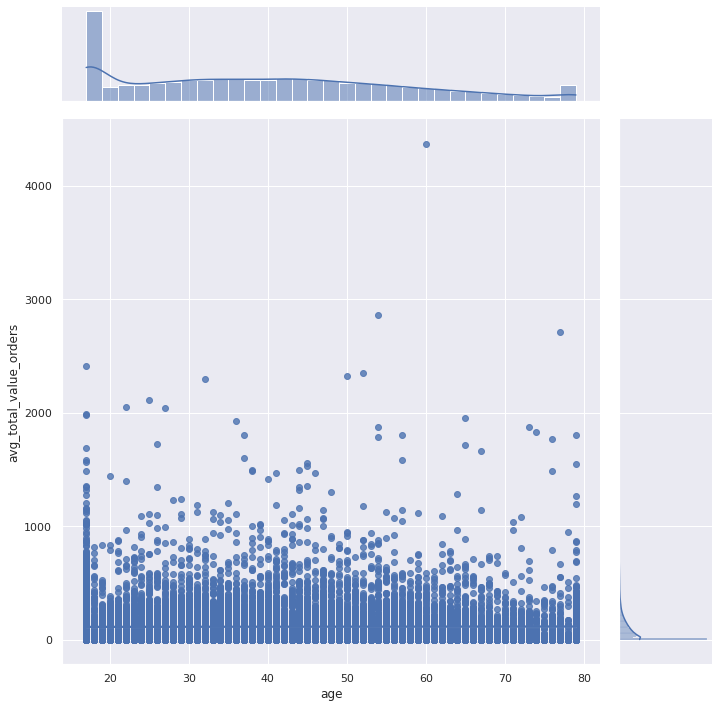

In [61]:
sns.jointplot(data=df_clean_2, x="age", y="avg_total_value_orders", kind="reg", height=10)

Aparentemente não existe relação

## Score de crédito X Média do valor total gasto por pedido

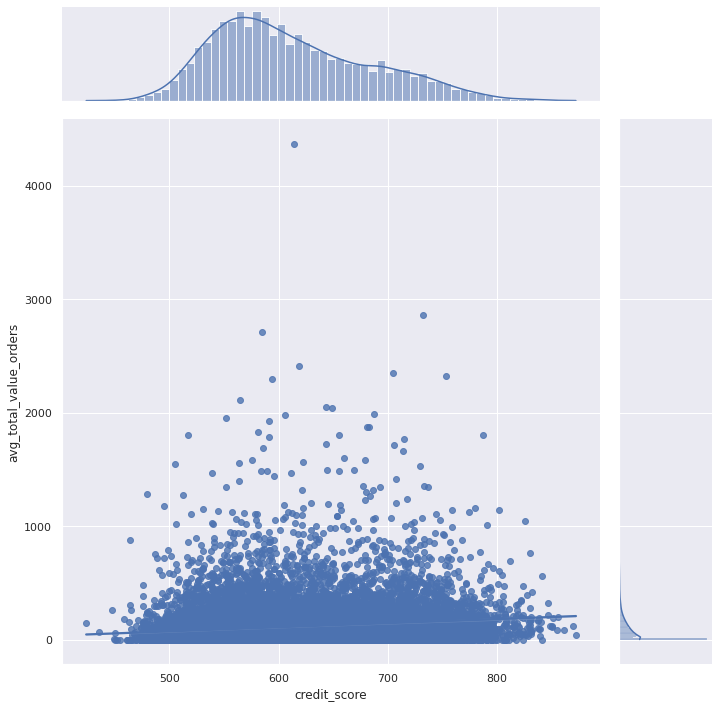

In [62]:
sns.jointplot(data=df_clean_2, x="credit_score", y="avg_total_value_orders", kind="reg", height=10)

Existe uma relação ligeiramente positiva, ou seja, maior o score de crédito, maior a valor médio dos pedidos



## Pairplot

Analisando varias variaveis de uma só vez

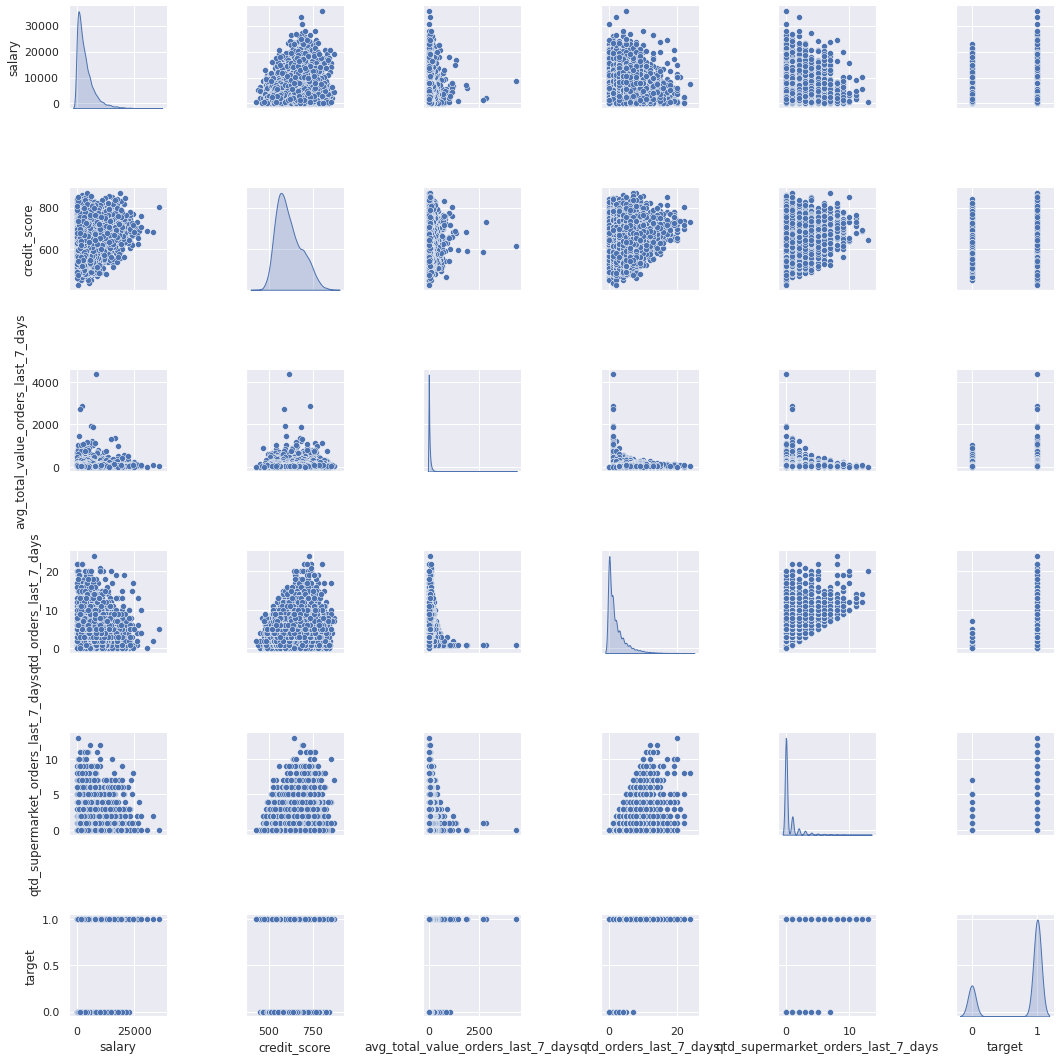

In [63]:
VALS = ['salary', 'credit_score',
       'avg_total_value_orders_last_7_days', 'qtd_orders_last_7_days',
       'qtd_supermarket_orders_last_7_days', 
       'target']
sns.pairplot(df_clean_2[VALS], diag_kind="kde")